In [1]:
import torch
import matplotlib.pyplot as plt
import timeit
import scaleformer
from scaleformer._functions import mask_chronological

In [2]:
R = 16
N = 10
h = 4
d = 64
num_repeats = 100

In [3]:
def time(function, num_repeats: int) -> float:
    """
    times a function execution in ms
    """
    timings = timeit.repeat(function, number=1, repeat=num_repeats)
    return min(timings)

## 1) Attention timing

In [4]:
def naive_attention(q, k, v, masked):
    return scaleformer._scalable_attention.ScalableAttention._naive_kernelized_attention(None, q, k, v, masked)

def linear_attention(q, k, v, masked):
    return scaleformer._scalable_attention.ScalableAttention._linear_kernelized_attention(None, q, k, v, masked)

In [5]:
naive_masked = []
naive_bidirectional = []
linear_masked = []
linear_bidirectional = []
sequence_length = []

for l in [2**i for i in range(4, 11)]:
    print(f"sequence of length {l}")
    Lq, Lk = l, l
    # tensors
    q = torch.rand((N, 1, Lq, d))
    v = torch.rand((N, 1, Lk, d))
    k = torch.rand((N, 1, Lk, d))
    # timing
    sequence_length.append(l)
    naive_masked.append(time(lambda: naive_attention(q, k, v, masked=True), num_repeats))
    naive_bidirectional.append(time(lambda: naive_attention(q, k, v, masked=False), num_repeats))
    linear_masked.append(time(lambda: linear_attention(q, k, v, masked=True), num_repeats))
    linear_bidirectional.append(time(lambda: linear_attention(q, k, v, masked=False), num_repeats))

sequence of length 16
sequence of length 32
sequence of length 64
sequence of length 128
sequence of length 256
sequence of length 512
sequence of length 1024


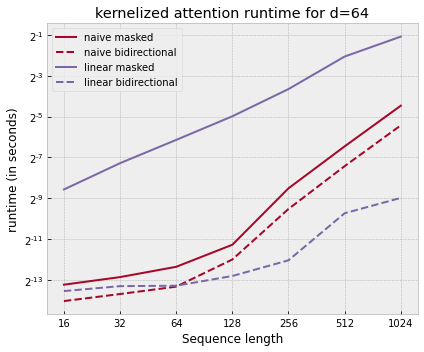

In [6]:
plt.style.use("bmh")
f, ax = plt.subplots(figsize=[6, 5])
ax.set_title(f"kernelized attention runtime for d={d}")
ax.set_xscale("log", basex=2)
ax.set_yscale("log", basey=2)
ax.set_xlabel("Sequence length")
ax.set_ylabel("runtime (in seconds)")
ax.plot(sequence_length, naive_masked, color="C1", linestyle="-", label="naive masked")
ax.plot(sequence_length, naive_bidirectional, linestyle="--", color="C1", label="naive bidirectional")
ax.plot(sequence_length, linear_masked, linestyle="-", color="C2", label="linear masked")
ax.plot(sequence_length, linear_bidirectional, linestyle="--", color="C2", label="linear bidirectional")
ax.set_xticks(sequence_length)
ax.set_xticklabels([f"{l}" for l in sequence_length])
f.tight_layout()
plt.legend()
plt.show()

#### Checking equality between linear and naive implementations

In [7]:
torch.allclose(naive_attention(q, k, v, masked=True),
               linear_attention(q, k, v, masked=True))

True

In [8]:
torch.allclose(naive_attention(q, k, v, masked=False),
               linear_attention(q, k, v, masked=False))

True

## 2) Relative positional encoding timing

In [9]:
def naive_RPE(q, RPE, v, masked: bool):
    return scaleformer._scalable_attention.ScalableAttention._naive_RPE(None, q, RPE, v, masked=masked)


def linear_RPE(q, RPE, v, masked: bool):
    return scaleformer._scalable_attention.ScalableAttention._linear_RPE(None, q, RPE, v, masked=masked)

In [10]:
naive_masked = []
naive_bidirectional = []
linear_masked = []
linear_bidirectional = []
sequence_length = []

for l in [2**i for i in range(4, 11)]:
    print(f"sequence of length {l}")
    Lq, Lk = l, l
    # tensors
    q = torch.rand((N, 1, Lq, d))
    RPE = torch.rand((2*R+1, d))
    v = torch.rand((N, 1, Lk, d))
    # timing
    sequence_length.append(l)
    naive_masked.append(time(lambda: naive_RPE(q, RPE, v, masked=True), num_repeats))
    naive_bidirectional.append(time(lambda: naive_RPE(q, RPE, v, masked=False), num_repeats))
    linear_masked.append(time(lambda: linear_RPE(q, RPE, v, masked=True), num_repeats))
    linear_bidirectional.append(time(lambda: linear_RPE(q, RPE, v, masked=False), num_repeats))

sequence of length 16
sequence of length 32
sequence of length 64
sequence of length 128
sequence of length 256
sequence of length 512
sequence of length 1024


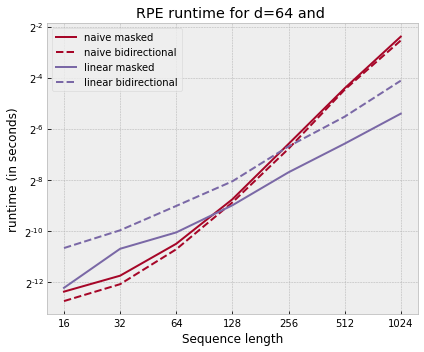

In [11]:
plt.style.use("bmh")
f, ax = plt.subplots(figsize=[6, 5])
ax.set_title(f"RPE runtime for d={d} and ")
ax.set_xscale("log", basex=2)
ax.set_yscale("log", basey=2)
ax.set_xlabel("Sequence length")
ax.set_ylabel("runtime (in seconds)")
ax.plot(sequence_length, naive_masked, color="C1", linestyle="-", label="naive masked")
ax.plot(sequence_length, naive_bidirectional, linestyle="--", color="C1", label="naive bidirectional")
ax.plot(sequence_length, linear_masked, linestyle="-", color="C2", label="linear masked")
ax.plot(sequence_length, linear_bidirectional, linestyle="--", color="C2", label="linear bidirectional")
ax.set_xticks(sequence_length)
ax.set_xticklabels(f"{l}" for l in sequence_length)
f.tight_layout()
plt.legend()
plt.show()

#### Checking equality between linear and naive implementations

In [12]:
torch.allclose(naive_RPE(q, RPE, v, masked=True),
               linear_RPE(q, RPE, v, masked=True))

True

In [13]:
torch.allclose(naive_RPE(q, RPE, v, masked=False),
               linear_RPE(q, RPE, v, masked=False))

True

## 3) Multi head attention timing